In [1]:
import os
import sys

MODULE_PATH = '/content/drive/MyDrive/GitHub/DL_Study/CNN'

sys.path.insert(0, MODULE_PATH)
sys.path

['/content/drive/MyDrive/GitHub/DL_Study/CNN',
 '',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [2]:
# import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy

from ShuffleNet import *

torch.manual_seed(42)

# for time series split
!pip install scikit-learn==0.24.2

     |████████████████████████████████| 22.3MB 69.0MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [3]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

def np_to_tensor(data):
    device = get_device()
    return torch.tensor(data).float().to(device)

# configuration setting
def model_config():
    # parameter for CNN Model
    epochs = [30]
    batch_size = [64]
    learning_rate = [0.01, 0.001]
    
    # create config data
    configs = []
    for i in epochs:
        for j in batch_size:
            for k in learning_rate:
                config = [i, j, k]
                configs.append(config)
    return configs

# fucntion for fit cnn model using configs
def model_fit(train_X, train_y, config, verbose=0):

    # unpack config
    n_epochs, n_batch, learning_rate = config
    # use ShuffleNet for CNN
    model = ShuffleNet(groups=3, in_channels=1)
    if torch.cuda.is_available():
        model.cuda()

    # define Loss and Optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    data_size = train_X.size(0)
    max_iters = data_size//n_batch

    for epoch in range(1, n_epochs+1):
        #shuffle data
        idx = numpy.random.permutation(numpy.arange(data_size))
        x_data = train_X[idx]
        y_data = train_y[idx]

        epoch_loss = 0
        start_time = time.time()
        for it in range(max_iters):
            batch_x = x_data[it*n_batch:(it+1)*n_batch]
            batch_y = y_data[it*n_batch:(it+1)*n_batch]

            optimizer.zero_grad()
            predict = model(batch_x)
            loss = criterion(predict, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss+= loss.item()
        avg_loss = epoch_loss/max_iters

        if verbose:
            duration = start_time-time.time()
            print(f'epoch:{epoch}/{epochs}, ì‹œê°„:{duration:.2f}[s], loss:{avg_loss:.5f}')


    return model

def MAE_metric(x, t):
    t = np.array(t)
    return np.mean(numpy.abs(x-t))

def MSE_metric(x, t):
    t = np.array(t)
    return np.mean((x-t)**2)

In [4]:
import zipfile, requests, io
import pandas as pd
import numpy as np
import numpy
import time
from datetime import datetime

numpy.random.seed(42)
np.random.seed(42)

data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00374/'
data_name = 'energydata_complete.csv'
df = pd.read_csv(data_url+data_name)
df.drop(columns=df.columns[[0, 27, 28]], axis=1, inplace=True)
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9


In [5]:
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller

# jb = (n/6)*(skewness**2 + (kurtosis**2/4))

def data_statistics(df):
    df = df.dropna()
    data = df.values
    num = len(df)
    skewness_ = skew(data)
    kurtosis_ = kurtosis(data)
    jarque_bera_ = (num/6)*(skewness_**2 + (kurtosis_**2/4))
    result = adfuller(data)
    adf_ = result[0]
    print(f'skewness : {skewness_}')
    print(f'kurtosis : {kurtosis_}')
    print(f'jarque bera : {jarque_bera_}')
    print(f'ADF : {adf_}')

data_statistics(df['Appliances'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


skewness : 3.3861098213774237
kurtosis : 13.66409667104885
jarque bera : 191240.7813698918
ADF : -21.616378198036216


In [6]:
df.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000


In [7]:
df.isnull().sum()

Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
dtype: int64

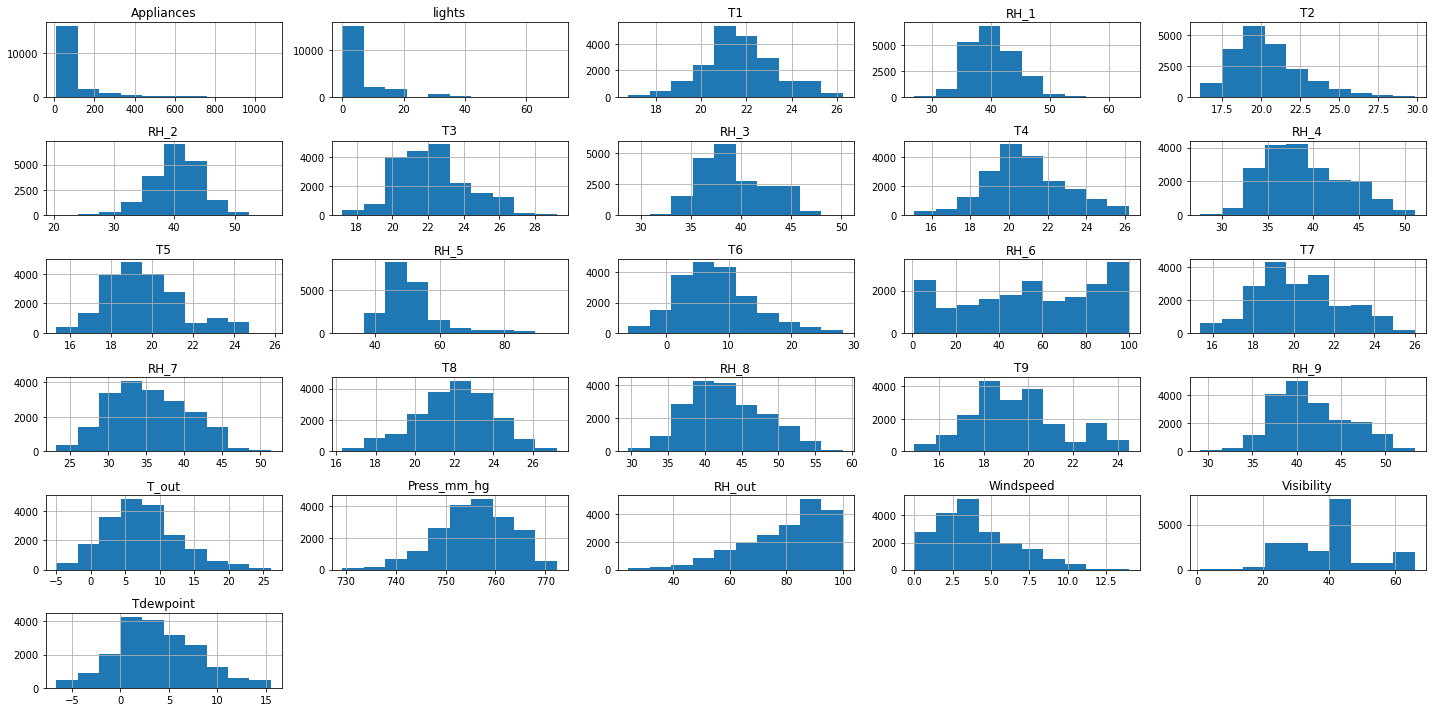

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

df.hist(figsize=(20, 10))
plt.tight_layout()
plt.show()

In [9]:
# series data to img function
def series_to_img(dataset, time_step=1):
    num = dataset.shape[1]      # features num
    df = pd.DataFrame(dataset)
    cols, names = list(), list()
    # sequence t-n to t-1
    for i in range(time_step, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(num)]

    for i in range(0, 1):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(num)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(num)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    return agg

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

dataset = df.values
dataset = dataset.astype('float')

n_inputs = 24
n_features = 26
del_idx = n_inputs * n_features + 1
del_cols = [i for i in range(del_idx, del_idx+n_features-1)]
new_df = series_to_img(dataset, n_inputs)
new_df.drop(new_df.columns[del_cols], axis=1, inplace=True)

In [10]:
n_splits = 10
train_test_split = TimeSeriesSplit(n_splits=n_splits+1, gap=n_inputs).split(new_df)
next(train_test_split)

configs = model_config()
history = []

best_rmse, best_mse, best_mae = [], [], []

i = 1

print('config : epochs, batch_size, learning_rate')

# nested cross validation for time series model
for train_cv_indices, test_cv_indices in train_test_split:
    print(f'fold : {i}/{n_splits}')
    i+=1

    # split x, y data
    train_cv_X, train_cv_y = new_df.iloc[train_cv_indices, :-1].values, new_df.iloc[train_cv_indices,-1].values
    test_cv_X, test_cv_y = new_df.iloc[test_cv_indices, :-1].values, new_df.iloc[test_cv_indices, -1].values

    # length for validation set
    test_length = int(len(train_cv_X)*0.2)

    # scaling data
    scaler_x = MinMaxScaler()
    train_cv_X = scaler_x.fit_transform(train_cv_X)
    test_cv_X = scaler_x.transform(test_cv_X)

    train_X, val_X = train_cv_X[:-test_length, :], train_cv_X[-test_length:, :]
    train_y, val_y = train_cv_y[:-test_length], train_cv_y[-test_length:]

    # reshape
    # inner loop
    train_X = train_X.reshape(-1, 1, n_inputs, n_features)
    val_X = val_X.reshape(-1, 1, n_inputs, n_features)
    train_y = train_y.reshape(-1, 1)
    val_y = val_y.reshape(-1, 1)

    # outer loop
    train_cv_X = train_cv_X.reshape(-1, 1, n_inputs, n_features)
    test_cv_X = test_cv_X.reshape(-1, 1, n_inputs, n_features)
    train_cv_y = train_cv_y.reshape(-1, 1)
    test_cv_y = test_cv_y.reshape(-1, 1)

    train_X = np_to_tensor(train_X)
    train_y = np_to_tensor(train_y)
    val_X = np_to_tensor(val_X)
    val_y = np_to_tensor(val_y)
    train_cv_X = np_to_tensor(train_cv_X)
    train_cv_y = np_to_tensor(train_cv_y)
    test_cv_X = np_to_tensor(test_cv_X)
    test_cv_y = np_to_tensor(test_cv_y)

    # model fit, inner
    errors = []
    for idx, cfg in enumerate(configs):
        print(f' == train {cfg} model == ', end=' ')
        model = model_fit(train_X, train_y, cfg)
        predicted = model(val_X)
        error = F.mse_loss(predicted, val_y)   # rmse
        print(f'error(rmse):{error.item():.2f}')
        if errors:
            if error.item() < min(errors):
                param = idx
        else:
            param = idx
        errors.append(error.item())

    history.append(errors)

    # outer
    selected_model = model_fit(train_cv_X,train_cv_y, configs[param])
    predicted = selected_model(test_cv_X)
    rmse = np.sqrt(F.mse_loss(predicted, test_cv_y).item())
    mse = F.mse_loss(predicted, test_cv_y)
    mae = F.l1_loss(predicted, test_cv_y)
    best_rmse.append(rmse)
    best_mse.append(mse.item())
    best_mae.append(mae.item())

    # model eval
    print(f'train-size:{train_X.size(0)}, val-size:{val_X.size(0)}, test-size:{test_cv_X.size(0)}')
    print(f'best_model => error(rmse) : {rmse:.2f}, param:{configs[param]}')
    print()

config : epochs, batch_size, learning_rate
fold : 1/10
 == train [30, 64, 0.01] model ==  

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


error(rmse):15106.67
 == train [30, 64, 0.001] model ==  error(rmse):20139.85
train-size:2614, val-size:653, test-size:1642
best_model => error(rmse) : 94.18, param:[30, 64, 0.01]

fold : 2/10
 == train [30, 64, 0.01] model ==  error(rmse):8569.82
 == train [30, 64, 0.001] model ==  error(rmse):11142.06
train-size:3928, val-size:981, test-size:1642
best_model => error(rmse) : 85.46, param:[30, 64, 0.01]

fold : 3/10
 == train [30, 64, 0.01] model ==  error(rmse):5263.65
 == train [30, 64, 0.001] model ==  error(rmse):9041.21
train-size:5241, val-size:1310, test-size:1642
best_model => error(rmse) : 86.50, param:[30, 64, 0.01]

fold : 4/10
 == train [30, 64, 0.01] model ==  error(rmse):5784.85
 == train [30, 64, 0.001] model ==  error(rmse):7779.23
train-size:6555, val-size:1638, test-size:1642
best_model => error(rmse) : 77.76, param:[30, 64, 0.01]

fold : 5/10
 == train [30, 64, 0.01] model ==  error(rmse):5836.69
 == train [30, 64, 0.001] model ==  error(rmse):8835.70
train-size:7868

In [11]:
predicted = selected_model(test_cv_X)

def model_evaluation(mse, rmse, mae):
    mse = np.array(mse)
    rmse = np.array(rmse)
    mae = np.array(mae)
    print(f'MSE: mean={np.mean(mse)}, std={np.std(mse)}')
    print(f'RMSE: mean={np.mean(rmse)}, std={np.std(rmse)}')
    print(f'MAE: mean={np.mean(mae)}, std={np.std(mae)}')

model_evaluation(best_mse, best_rmse, best_mae)

MSE: mean=5866.646142578125, std=1521.490807796708
RMSE: mean=75.96674122940206, std=9.782656569827623
MAE: mean=37.614295387268065, std=7.429430158462718
